In [1]:
%load_ext autoreload
%autoreload 2

# This is needed to display the images.
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from glob import glob

In [3]:
from TLClassifier import TLClassifier

In [4]:
%time
test_file = "dayClip6--00332.jpg"

from PIL import Image
im = Image.open(test_file)
image_np = np.asarray(im)

Wall time: 0 ns


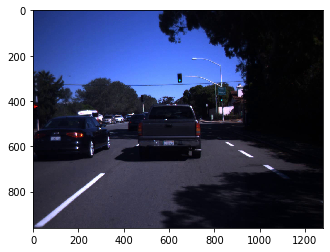

In [5]:
plt.imshow(image_np)

In [6]:
# Instanciating a TL classifier
tlc = TLClassifier()

In [7]:
# I think this function is used to crop the image using the detected box coordinates

def crop_roi_image(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image

Wall time: 0 ns


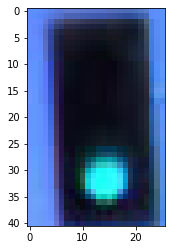

In [8]:
%time
# Detecting the objects in the given image and returning them as "boxes"
boxes = tlc.detect_multi_object(image_np,score_threshold=0.2)
# Cropping the image as many times as the boxes detected
# I think here is used just the first detected for example
cropped_image=crop_roi_image(image_np,boxes[0])
plt.imshow(cropped_image)

# Classify the color by human intelligence

In [9]:
# Convert the cropped image into HSV space

#   From wikipedia:
#   "HSL (hue, saturation, lightness) and HSV 
#   (hue, saturation, value, also known as HSB or hue, saturation, brightness) 
#   are alternative representations of the RGB color model"

#   In particular:
#   "The HSV representation models how colors appear under light."

from skimage.color import rgb2grey, rgb2hsv
hsv_test_image = rgb2hsv(cropped_image)

#   I think this is used to separate the colours in an image using their three value components

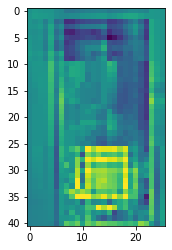

In [10]:
#   Show saturation values
plt.imshow(hsv_test_image[:,:,1])

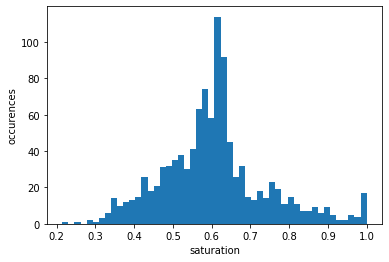

In [11]:
#   Checking the histogram to decide the filtering threshold

s_val_1d = hsv_test_image[:,:,1].ravel()
plt.hist(s_val_1d,bins=50)
plt.xlabel("saturation")
plt.ylabel("occurences")
plt.show()

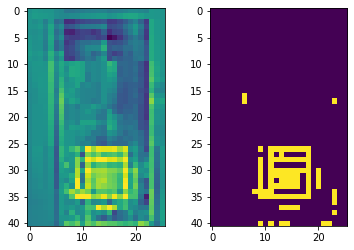

In [12]:
#   Select the high-saturation region for further classification

#   np.ones_like(): "Return an array of ones with the same shape and type as a given array"  

saturation_threshold=0.8

idx = hsv_test_image[:, :, 1] <= saturation_threshold
sat_mask = np.ones_like(hsv_test_image[:, :, 1])
sat_mask[idx] = 0

#   I think here we have just categorized the colors in the image in two classes,
#   depending on if the pixel color has a saturation higher than the treshold or not.

fig,ax = plt.subplots(nrows=1,ncols=2)
ax[0].imshow(hsv_test_image[:,:,1])
ax[1].imshow(sat_mask)

In [13]:
#   We perform similar operation for Value channle

def high_value_region_mask(hsv_image, v_thres=0.6):
    if hsv_image.dtype == np.int:
        idx = (hsv_image[:, :, 2].astype(np.float) / 255.0) < v_thres
    else:
        idx = (hsv_image[:, :, 2].astype(np.float)) < v_thres
    mask = np.ones_like(hsv_image[:, :, 2])
    mask[idx] = 0
    return mask

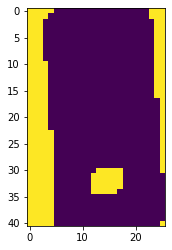

In [14]:
#  Same as before but with different treshold?

v_thres_val = 0.9
val_mask = high_value_region_mask(hsv_test_image, v_thres=v_thres_val)
plt.imshow(val_mask)

In [15]:
#   By performing these two masks, we reach the following mask 
#   for selecting the region to calculate the average HUE VALUES

#   "HUE distinguishes one color from another and is described using 
#   common color names such as green, blue, red, yellow, etc. 
#   VALUE refers to the lightness or darkness of a color. 
#   It defines a color in terms of how close it is to white or black."

def get_masked_hue_image(hsv_test_image):

    s_thres_val = channel_percentile(hsv_test_image[:, :, 1], percentile=70)
    v_thres_val = channel_percentile(hsv_test_image[:, :, 2], percentile=70)
    val_mask = high_value_region_mask(hsv_test_image, v_thres=v_thres_val)
    sat_mask = high_saturation_region_mask(hsv_test_image, s_thres=s_thres_val)
    masked_hue_image = hsv_test_image[:, :, 0]
    return masked_hue_image

In [16]:
#   Filtering out the region of interest

#   Same concept as before, see high_value_region_mask()
def high_saturation_region_mask(hsv_image, s_thres=0.6):
    if hsv_image.dtype == np.int:
        idx = (hsv_image[:, :, 1].astype(np.float) / 255.0) < s_thres
    else:
        idx = (hsv_image[:, :, 1].astype(np.float)) < s_thres
    mask = np.ones_like(hsv_image[:, :, 1])
    mask[idx] = 0
    return mask


def channel_percentile(single_chan_image, percentile):
    sq_image = np.squeeze(single_chan_image)
    assert len(sq_image.shape) < 3

    thres_value = np.percentile(sq_image.ravel(), percentile)

    return float(thres_value) / 255.0

Text(0.5, 1.0, 'mask to be applied')

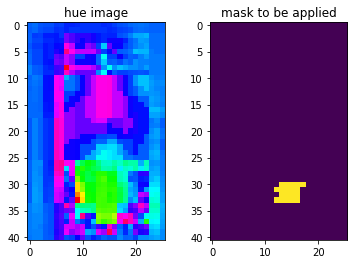

In [17]:
hue_image = hsv_test_image[:,:,0]
fig,ax = plt.subplots(nrows=1,ncols=2)
#   Showing the image in HSV format
ax[0].imshow(hue_image,cmap='hsv')
ax[0].set_title("hue image")
#   The mask to be applied is created from the two previous ones
ax[1].imshow(np.logical_and(sat_mask,val_mask))
ax[1].set_title("mask to be applied")

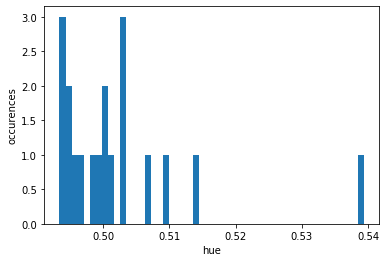

In [18]:
hue_1d = hue_image[np.logical_and(val_mask, sat_mask)].ravel()

#   I think here we are categorizing the predominant color that is inside the region
#   of the HUE image determined by the final mask (the yellow part in the right figure)
plt.hist(hue_1d,bins=50)
plt.xlabel("hue")
plt.ylabel("occurences")
plt.show()

In [19]:
#   The hue values in this region is near 0.5, which is green.

def get_masked_hue_values(rgb_image):
    """
    Get the pixels in the RGB image that has high saturation (S) and value (V) in HSV channels

    :param rgb_image: image (height, width, channel)
    :return: a 1-d array
    """

    hsv_test_image = rgb2hsv(rgb_image)
    #   Defining the tresholds values for the two masks
    s_thres_val = channel_percentile(hsv_test_image[:, :, 1], percentile=30)
    v_thres_val = channel_percentile(hsv_test_image[:, :, 2], percentile=70)
    
    #   Getting the masks
    val_mask = high_value_region_mask(hsv_test_image, v_thres=v_thres_val)
    sat_mask = high_saturation_region_mask(hsv_test_image, s_thres=s_thres_val)
    
    masked_hue_image = hsv_test_image[:, :, 0] * 180
    # Note that the following statement is not equivalent to
    # masked_hue_1d= (maksed_hue_image*np.logical_and(val_mask,sat_mask)).ravel()
    # Because zero in hue channel means red, we cannot just set unused pixels to zero.
    
    #   Finally masking the image
    masked_hue_1d = masked_hue_image[np.logical_and(val_mask, sat_mask)].ravel()

    return masked_hue_1d

def convert_to_hue_angle(hue_array):
    """
    Convert the hue values from [0,179] to radian degrees [-pi, pi]

    :param hue_array: array-like, the hue values in degree [0,179]
    :return: the angles of hue values in radians [-pi, pi]
    """

    hue_cos = np.cos(hue_array * np.pi / 90)
    hue_sine = np.sin(hue_array * np.pi / 90)

    hue_angle = np.arctan2(hue_sine, hue_cos)

    return hue_angle

In [20]:
#   The following codes detects the color by hue values of an image.

def get_rgy_color_mask(hue_value, from_01=False):
    """
    return a tuple of np.ndarray that sets the pixels with red, green and yellow matrices to be true

    :param hue_value:
    :param from_01: True if the hue values is scaled from 0-1 (scikit-image), otherwise is -pi to pi
    :return:
    """

    if from_01:
        n_hue_value = conver_to_hue_angle_from_01(hue_value)
    else:
        n_hue_value = hue_value

    red_index = np.logical_and(n_hue_value < (0.125 * np.pi), n_hue_value > (-0.125 * np.pi))

    green_index = np.logical_and(n_hue_value > (0.66 * np.pi), n_hue_value < np.pi)

    yellow_index = np.logical_and(n_hue_value > (0.25 * np.pi), n_hue_value < (5.0 / 12.0 * np.pi))

    return red_index, green_index, yellow_index

def classify_color_by_range(hue_value):
    """
    Determine the color (red, yellow or green) in a hue value array

    :param hue_value: hue_value is radians
    :return: the color index ['red', 'yellow', 'green', '_', 'unknown']
    """

    red_index, green_index, yellow_index = get_rgy_color_mask(hue_value)

    color_counts = np.array([np.sum(red_index) / len(hue_value),
                             np.sum(yellow_index) / len(hue_value),
                             np.sum(green_index) / len(hue_value)])

    color_text = ['red', 'yellow', 'green', '_', 'unknown']

    min_index = np.argmax(color_counts)

    return min_index, color_text[min_index]

def classify_color_cropped_image(rgb_image):
    """
    Full pipeline of classifying the traffic light color from the traffic light image

    :param rgb_image: the RGB image array (height,width, RGB channel)
    :return: the color index ['red', 'yellow', 'green', '_', 'unknown']
    """

    hue_1d_deg = get_masked_hue_values(rgb_image)

    if len(hue_1d_deg) == 0:
        return 4, 'unknown'

    hue_1d_rad = convert_to_hue_angle(hue_1d_deg)

    return classify_color_by_range(hue_1d_rad)

In [21]:
classify_color_cropped_image(cropped_image)

(2, 'green')

## Predictions

In [22]:
boxes=tlc.detect_multi_object(image_np,score_threshold=0.1)

In [23]:
def classify_all_boxes_in_image(image_np, boxes):
    result_index_array = np.zeros(boxes.shape[0], dtype=np.int)
    for i, box in enumerate(boxes):
        cropped_image = crop_roi_image(image_np, box)
        result_color_index, _ = classify_color_cropped_image(cropped_image)
        result_index_array[i] = result_color_index

    return result_index_array

In [24]:
results_index=classify_all_boxes_in_image(image_np,boxes)

In [25]:
from vis_util import draw_result_on_image
def draw_results_on_image(image_np, boxes, tl_results_array):
    for i, box in enumerate(boxes):
        draw_result_on_image(image_np, box, tl_results_array[i])

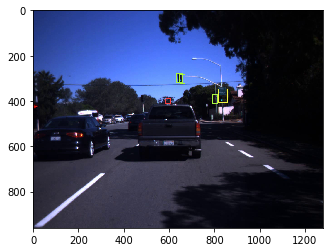

In [26]:
n_image_np=np.copy(image_np)
draw_results_on_image(n_image_np, boxes, results_index)
plt.imshow(n_image_np)

In [27]:
boxes

array([[0.29027677, 0.4951715 , 0.3323881 , 0.51550263],
       [0.29622158, 0.50590485, 0.33591834, 0.52479297],
       [0.36318436, 0.64009356, 0.42505965, 0.67147505],
       [0.40684217, 0.4576642 , 0.42892665, 0.4756801 ],
       [0.38792768, 0.6189158 , 0.42967227, 0.6353054 ]], dtype=float32)

In [28]:
from vehicle_model import vehicle_model

vmodel = vehicle_model()

Using TensorFlow backend.


array([[[254, 233, 216],
        [245, 238, 232],
        [196, 205, 212],
        ...,
        [ 16,  35,  52],
        [ 20,  37,  53],
        [ 32,  48,  63]],

       [[245, 238, 232],
        [188, 193, 197],
        [137, 158, 175],
        ...,
        [ 74, 108, 135],
        [ 47,  77, 103],
        [  4,  34,  60]],

       [[193, 202, 209],
        [134, 157, 173],
        [115, 154, 183],
        ...,
        [ 95, 144, 184],
        [ 89, 137, 177],
        [ 52,  97, 136]],

       ...,

       [[141, 131, 129],
        [132, 121, 119],
        [114, 100,  97],
        ...,
        [ 99,  80,  74],
        [ 99,  80,  74],
        [113,  94,  88]],

       [[164, 154, 152],
        [133, 122, 120],
        [120, 106, 103],
        ...,
        [107,  88,  82],
        [109,  90,  84],
        [111,  92,  86]],

       [[189, 179, 177],
        [135, 125, 123],
        [128, 117, 113],
        ...,
        [ 97,  78,  72],
        [ 95,  76,  70],
        [ 73,  54,  48]]

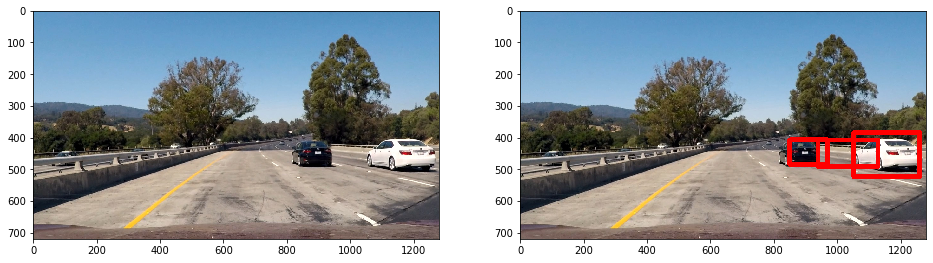

In [29]:
boxes = vmodel.predict('./test_images/test1.jpg')  
vmodel.draw_on_image(boxes, './test_images/test1.jpg')

# Check Overlap
Here we are checking if the boxes with parameters [x,y,width,height] with the x, y being the top left coordinate of the box

In [30]:
from overlap_boxes import isInside

# Change these parameters
bigRect = [1, 3, 4, 3]
smallRect = [2, 2, 3, 2]

print("Is the small rectangle completely inside?", isInside(np.asarray(bigRect), np.asarray(smallRect)))

Is the small rectangle completely inside? True


# Predict both
Function to predict both Traffic light and vehicle and return the boxes

In [31]:
def predict_both(image_path):
    # first predict vehicle then predict traffic light
    im = Image.open(image_path)
    image_np = np.asarray(im)
    vehicle_boxes = vmodel.predict(image_path)  
    tl_boxes = tlc.detect_multi_object(image_np,score_threshold=0.1)
    return vehicle_boxes, tl_boxes

In [32]:
def draw_both(image_path,image_out_path, vehicle_boxes, tl_boxes):
    # Traffic light boxes
    im = Image.open(image_path)
    n_image_np = np.asarray(im)
    copy = np.copy(n_image_np)
    results_index=classify_all_boxes_in_image(n_image_np,tl_boxes)
    draw_results_on_image(copy, tl_boxes, results_index)
    outimage = Image.fromarray(copy)
    outimage.save(image_out_path)
    boxedim = vmodel.draw_on_image(vehicle_boxes, image_out_path)
    outimage = Image.fromarray(boxedim)
    outimage.save(image_out_path)

In [33]:
vehicle_box, tl_box = predict_both("dayClip6--00332.jpg")

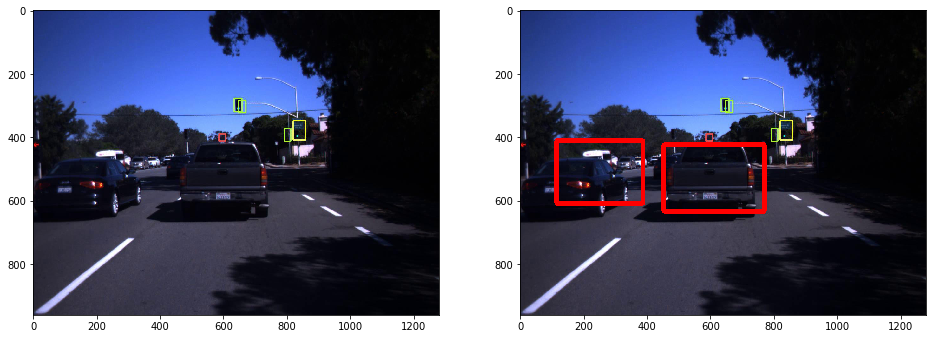

In [34]:
draw_both("dayClip6--00332.jpg","test.jpg", vehicle_box, tl_box)

In [35]:
predict_both('./test_images/test1.jpg') # no traffic lights in the image above so this looks correct

([<utils.utils.Box at 0x1fb2d889548>,
 array([], shape=(0, 4), dtype=float32))

In [36]:
predict_both("dayClip6--00332.jpg") # 2 vehicle in this image looks correct

([<utils.utils.Box at 0x1fb2d831648>, <utils.utils.Box at 0x1fb31ae6208>],
 array([[0.29027677, 0.4951715 , 0.3323881 , 0.51550263],
        [0.29622158, 0.50590485, 0.33591834, 0.52479297],
        [0.36318436, 0.64009356, 0.42505965, 0.67147505],
        [0.40684217, 0.4576642 , 0.42892665, 0.4756801 ],
        [0.38792768, 0.6189158 , 0.42967227, 0.6353054 ]], dtype=float32))

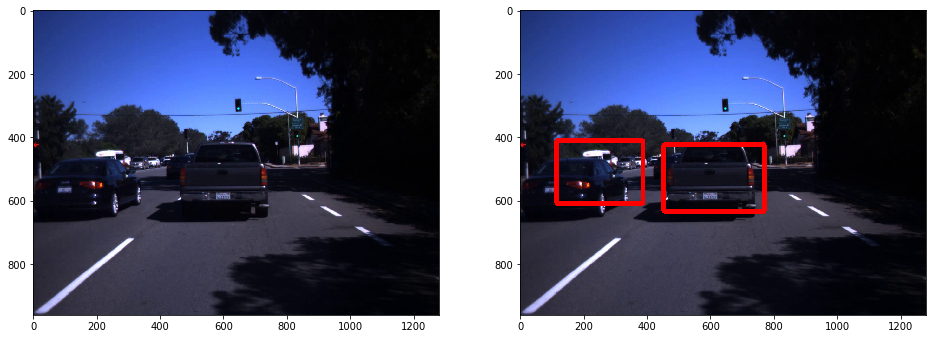

In [39]:
boxes = vmodel.predict('dayClip6--00332.jpg')  
drawn = vmodel.draw_on_image(boxes, 'dayClip6--00332.jpg')

# Testing 
This tests the vehicle model on a video clip

In [38]:
# vmodel.clip_predict('./project_video.mp4', './project_video_output.mp4')